## Data analysis

In this section we will look at the data to check how many proteins and chemicals are used as information for the rest of the code.

In [3]:
import pandas as pd
import numpy as np
import pickle
import sys

In [4]:
protein_set = set()
chemical_set = set()
with open("activity_train.csv", "r") as f:
    count = -1
    max_count = (-1, "")
    protein = ""
    for line in f.readlines():
        rating_line = line.strip().split(",")
        chemical_set.add(rating_line[1])
        if rating_line[0] != protein:
            if count > max_count[0]:
                max_count = (count, protein)
            protein = rating_line[0]
            count = 0
            protein_set.add(protein)
        count += 1
    print("Total number of protein : ", len(protein_set))
    print(f"The protein with the most interactions is {max_count[1]} with {max_count[0]} interactions")
print(len(protein_set))
print(len(chemical_set))

Total number of protein :  144
The protein with the most interactions is P14416 with 8045 interactions
144
72632


In [5]:
with open("activity_test_blanked.csv", "r") as f:
    count = -1
    max_count = (-1, "")
    protein = ""
    for line in f.readlines():
        rating_line = line.strip().split(",")
        chemical_set.add(rating_line[1])
        if rating_line[0] != protein:
            if count > max_count[0]:
                max_count = (count, protein)
            protein = rating_line[0]
            count = 0
            protein_set.add(protein)
        count += 1
    print("Total number of protein : ", len(protein_set))
    print(f"The protein with the most interactions is {max_count[1]} with {max_count[0]} interactions")
print(len(protein_set))
print(len(chemical_set))

Total number of protein :  144
The protein with the most interactions is P35372 with 657 interactions
144
73865


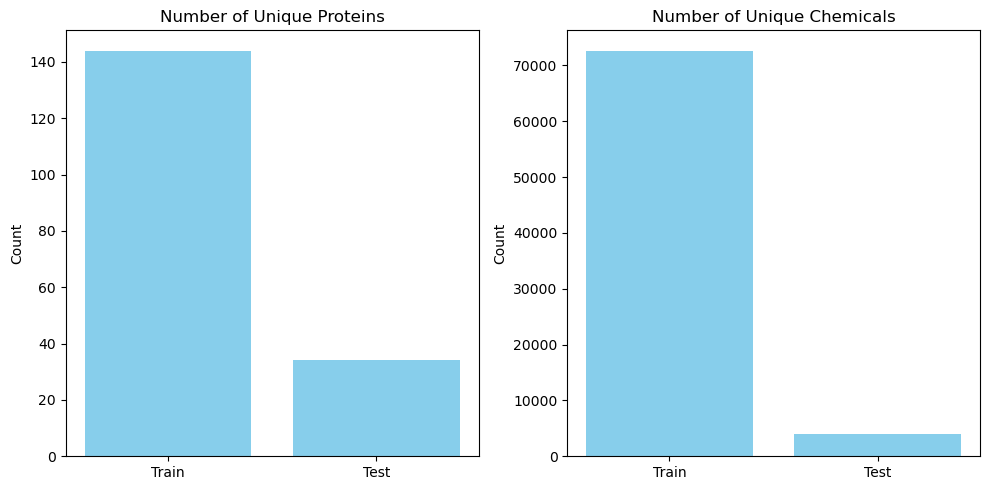

In [7]:
import matplotlib.pyplot as plt

# Initialize sets to store unique proteins and chemicals
protein_set_train = set()
chemical_set_train = set()
protein_set_test = set()
chemical_set_test = set()

# Read the training data
with open("activity_train.csv", "r") as f:
    for line in f.readlines():
        rating_line = line.strip().split(",")
        chemical_set_train.add(rating_line[1])
        protein_set_train.add(rating_line[0])

# Read the test data
with open("activity_test_blanked.csv", "r") as f:
    for line in f.readlines():
        rating_line = line.strip().split(",")
        chemical_set_test.add(rating_line[1])
        protein_set_test.add(rating_line[0])

# Count the number of unique proteins and chemicals
num_proteins_train = len(protein_set_train)
num_chemicals_train = len(chemical_set_train)
num_proteins_test = len(protein_set_test)
num_chemicals_test = len(chemical_set_test)

# Create a list of the counts for plotting
counts_proteins = [num_proteins_train, num_proteins_test]
counts_chemicals = [num_chemicals_train, num_chemicals_test]
labels = ['Train', 'Test']

# Plotting the histograms side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plotting for proteins
ax[0].bar(labels, counts_proteins, color='skyblue')
ax[0].set_title('Number of Unique Proteins')
ax[0].set_ylabel('Count')

# Plotting for chemicals
ax[1].bar(labels, counts_chemicals, color='skyblue')
ax[1].set_title('Number of Unique Chemicals')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


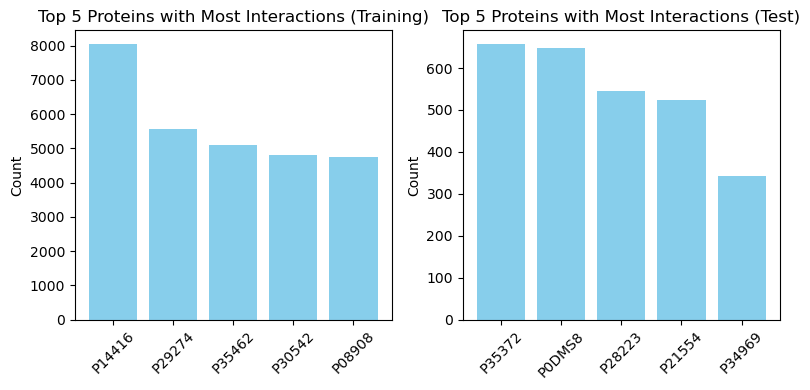

In [8]:
import matplotlib.pyplot as plt

# Count interactions for each protein in the training dataset
protein_interactions_train = {}
with open("activity_train.csv", "r") as f:
    for line in f.readlines():
        rating_line = line.strip().split(",")
        protein = rating_line[0]
        if protein in protein_interactions_train:
            protein_interactions_train[protein] += 1
        else:
            protein_interactions_train[protein] = 1

# Count interactions for each protein in the test dataset
protein_interactions_test = {}
with open("activity_test_blanked.csv", "r") as f:
    for line in f.readlines():
        rating_line = line.strip().split(",")
        protein = rating_line[0]
        if protein in protein_interactions_test:
            protein_interactions_test[protein] += 1
        else:
            protein_interactions_test[protein] = 1

# Sort the dictionaries by interaction counts and get top 5
top_proteins_train = sorted(protein_interactions_train.items(), key=lambda x: x[1], reverse=True)[:5]
top_proteins_test = sorted(protein_interactions_test.items(), key=lambda x: x[1], reverse=True)[:5]

# Extract protein names and interaction counts for plotting
protein_names_train, counts_train = zip(*top_proteins_train)
protein_names_test, counts_test = zip(*top_proteins_test)

# Plotting the histograms for top 5 proteins with most interactions
plt.figure(figsize=(8, 4))

# Plotting for training dataset
plt.subplot(1, 2, 1)
plt.bar(protein_names_train, counts_train, color='skyblue')
plt.title('Top 5 Proteins with Most Interactions (Training)')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plotting for test dataset
plt.subplot(1, 2, 2)
plt.bar(protein_names_test, counts_test, color='skyblue')
plt.title('Top 5 Proteins with Most Interactions (Test)')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [9]:
molecules_data=pickle.load(open("mol_bits.pkl", "rb"))
print(f"There is a total of {len(molecules_data)} molecules.")

There is a total of 73865 molecules.


We can see that there is 144 proteins and all the chemicals, 73865, from the "mol_bits" file are used.

## Data preprocessing

In this section we create all the data variables that are going to be used in the rest of the code.

In [10]:
protein_int_dict = {} # a dictionnary which keeps the correspondance between a protein and an int (its place in the ratings matix)
count = 0
for protein in protein_set:
    protein_int_dict[protein] = count
    count += 1

chemical_int_dict = {} # same as above for the chemicals
count = 0
for chemical in chemical_set:
    chemical_int_dict[chemical] = count
    count += 1

In [11]:
ratings = np.zeros([len(protein_set), len(chemical_set)])
with open("activity_train.csv", "r") as f:
    for line in f.readlines():
        rating_line = line.strip().split(",")
        prot_num = protein_int_dict[rating_line[0]]
        chem_num = chemical_int_dict[rating_line[1]]
        rating = rating_line[2]
        ratings[prot_num][chem_num] = rating

The ratings matrix contains the rating of every protein towards every chemicals where 0 means that there is no rating.

## Recommender system

In this section, we will try different methods to predict the ratings.

In [12]:
def RowCenterMatrix(M):
    V  = M.T
    mat= np.nanmean(V, axis=0)
    VC = V - mat
    VC[np.isnan(VC)]=0
    return VC.T

def CosSim_Matrix_Old(M):
    norms=np.sqrt(np.sum(M*M, axis=1))
    norms[norms<0.001]=0.001  #this will solve rows or cols without variance
    norms_M = np.outer(norms, norms)
    VC=M.copy()
    return np.dot(VC, VC.T)/norms_M

def CosSim_Matrix(M):
    return np.corrcoef(M)

def estimate_score(df, SM, nn, r,c, verbose=False):
    vals=df.values
    N,M=vals.shape
    sims=list(zip(SM[r], range(N)))
    sims.sort()
    sims.reverse()
    cnt=0
    S=0
    Ssims=0
    if verbose: print("row: %d - col: %d" % (r,c))
    for  sim, idx in sims[1:]:
        if not np.isnan(vals[idx, c]) and sim>0:
            cnt   += 1
            S     += sim*vals[idx, c]
            Ssims += sim
            if verbose: print(f"\tItem: {list(protein_int_dict.keys())[list(protein_int_dict.values()).index(idx)]}   Score:%4.1f (Sim: %6.3f)" %(vals[idx, c], sim))
        if cnt>= nn: break
    #this is the situation where no nighbours were found
    if Ssims<=0:
        #this is very inneficient!!! <- better have it precomputed 
        if verbose: print("\tNo similars: outputing the Global Baseline Average")
        M = np.nanmean(df.values)
        rA= np.nanmean(df.values[r])
        cA= np.nanmean(df.values[:,c])
        r = min(max(rA+cA-M,0),5)
        if verbose: print("\tScore: %7.4f" % r)
        return 1 + 0.9*r # we want the values to be between 1 and 10
    if verbose: print("\tScore: %7.4f" % (1 + (0.9 * S/Ssims)))
    return 1 + (0.9 * S/Ssims) # we want the values to be between 1 and 10

In [13]:
ratings_centered = RowCenterMatrix(ratings)

In [14]:
sim_mat = CosSim_Matrix_Old(ratings_centered)

In [15]:
output_str = ""
with open("activity_test_blanked.csv", "r") as f:
    for line in f.readlines():
        rating_line = line.strip().split(",")
        score = estimate_score(pd.DataFrame(ratings), sim_mat, 1000, protein_int_dict[rating_line[0]], chemical_int_dict[rating_line[1]])
        output_str += rating_line[0] + "," + rating_line[1] + "," + str(score) + "\n"

with open("preds_12.txt", "w") as f2:
    f2.write(output_str)

with open("PD_PREDS-12.csv", "w") as f2:
    f2.write(output_str)

## Results analysis

In this section, we will create the graphs to analyse the results.

count       4628.000000
mean           2.594015
std            1.886678
min            1.000000
25%            1.000000
50%            1.900000
75%            3.332500
max           10.000000
median         1.900000
variance       3.559552
skewness       1.545103
kurtosis       2.057460
Name: Score, dtype: float64


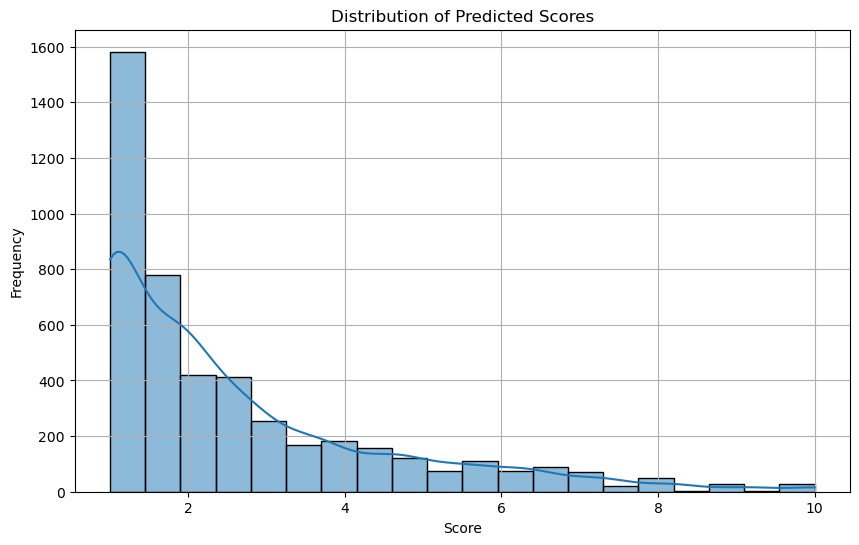

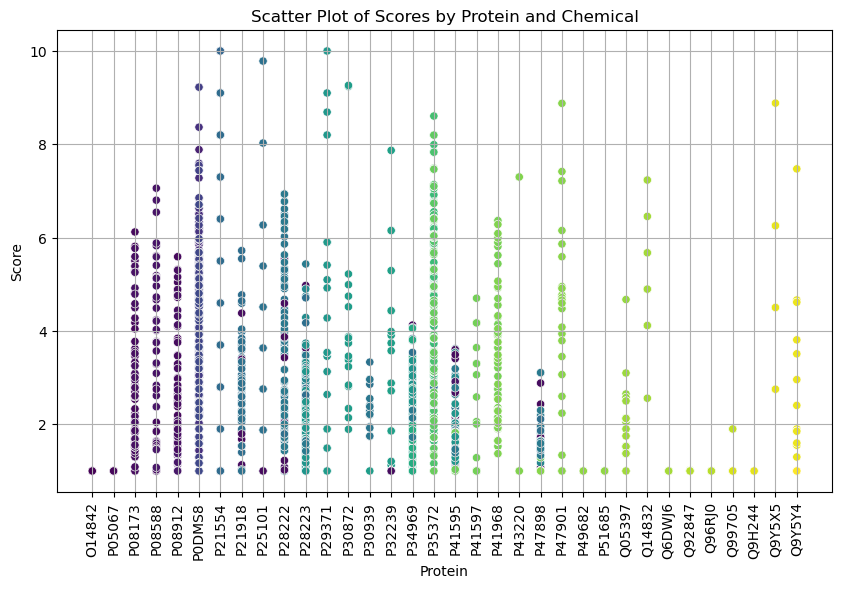

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis

# Reading the predictions from the output file
predictions = pd.read_csv("PD_PREDS-12.csv", header=None, names=["Protein", "Chemical", "Score"])

# Computing descriptive statistics
stats = predictions['Score'].describe()
stats['median'] = predictions['Score'].median()
stats['variance'] = predictions['Score'].var()
stats['skewness'] = skew(predictions['Score'])
stats['kurtosis'] = kurtosis(predictions['Score'])

# Print descriptive statistics
print(stats)

# Plotting the distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(predictions['Score'], bins=20, kde=True)
plt.title('Distribution of Predicted Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot to see if there's any visible trend in Protein-Chemical interaction scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=predictions, x="Protein", y="Score", hue="Chemical", palette="viridis", legend=None)
plt.title('Scatter Plot of Scores by Protein and Chemical')
plt.xlabel('Protein')
plt.ylabel('Score')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()
